<img src = "https://th.bing.com/th/id/OIP.HhUfenLp_nZ-QGte3_O1twHaE7?pid=ImgDet&rs=1" width = "1500">
<h2 align = 'center', style = 'font-size:48px'><strong>Earthquake Damage in Kavrepalanchok</strong></h2>

## Overview
In this notebook, I developed a model aimed at predicting eathquake in [Kavrepalanchok.](https://en.wikipedia.org/wiki/Kavrepalanchok_District). The purpose is to obtain the best model and the best depth for the prediction and to emphasize on the various steps needed to build such a model. I also explained the possible methods to deploy the model, these include wrapping the model in a function so that a programmer can provide inputs and then receive a prediction as output or creating an interactive dashboard, where a user can supply values and receive a prediction.

## About the data:
The was queried from a database comprising of four tables (id_map, building_structure, building damage and household_demographics) and four districts labelled 1 to 4. Myagdi is 1, Ramechhap is 2, and Gorkha is 4 of [Nepal Districts.](https://en.wikipedia.org/wiki/List_of_districts_of_Nepal). Then, What's the district ID for Kavrepalanchok? Did you say 3?! Yes, you are right. Kavrepalanchok is district ID 3 according to our database.

Since you may not have access to this database, I have saved the results of my query as `kavrepalanchok_raw.csv` which can the be wrangled (cleaned). The cleaned data, `kavrepalanchok_clean.csv`, gotten from my wragle function has also been provided for you to make use of - this as been made specifically for this project. Finally, `kavrepalanchok_test.csv` is also available to check for model performance.

## Algorithms Used
- Linear Regression
- Decision Tree Classifier

In [1]:
# Import libraries here
import warnings

import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from ipywidgets import interact, Dropdown, FloatSlider, IntSlider

warnings.simplefilter(action="ignore", category=FutureWarning)

# Prepare Data
## Connect to database

In [2]:
# %load_ext sql
# %sql sqlite:database pathway

**Query:** Join the unique building IDs from Kavrepalanchok in `id_map`, all the columns from  `building_structure`, and the **`damage_grade`** column from `building_damage`.

In [3]:
# %%sql 
# SELECT 
#     DISTINCT(i.building_id) AS b_id,
#     s.*,
#     d.damage_grade
# FROM id_map AS i
#     JOIN building_structure AS s ON i.building_id = s.building_id
#     JOIN building_damage AS d ON i.building_id = d.building_id    
# WHERE
#     district_id = 3

# Import

Write a `wrangle` function that will use the query you created in the previous task to create a DataFrame. In addition your function should:

1. Create a `"severe_damage"` column, where all buildings with a damage grade greater than `3` should be encoded as `1`. All other buildings should be encoded at `0`. 
2. Drop any columns that could cause issues with leakage or multicollinearity in your model.

In [4]:
# # Build your `wrangle` function here
# def wrangle(db_path):
#     # Connect to database
#     conn = sqlite3.connect(db_path)

#     # Construct query
#     query = """
#             SELECT 
#                 DISTINCT(i.building_id) AS b_id,
#                 s.*,
#                 d.damage_grade
#             FROM id_map AS i
#                 JOIN building_structure AS s ON i.building_id = s.building_id
#                 JOIN building_damage AS d ON i.building_id = d.building_id    
#             WHERE
#                 district_id = 3;
# """
            
#    # Read query results into DataFrame
#     df = pd.read_sql(query, conn, index_col = "b_id")
#     df.to_csv("kavrepalanchok_raw.csv")

#      # Identify leaky columns
#     drop_cols = [col for col in df.columns if "post_eq" in col]

#      # Add high-cardinality / redundant column
#     drop_cols.append("building_id")

#      # Create binary target column
#     df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
#     df["severe_damage"] = (df["damage_grade"] > 3).astype(int)

#      # Drop old target
#     drop_cols.append("damage_grade")

#     # Drop multicollinearity column
#     drop_cols.append("count_floors_pre_eq")
    
#     # Drop columns
#     df.drop(columns=drop_cols, inplace=True)
#     df.to_csv("kavrepalanchok_clean.csv")

#     return df

Use your `wrangle` function to query the database at `"database pathway"` and return  your cleaned results.

In [5]:
# df = wrangle("database pathway")
# df.head()

<h2 align = "center"> Now you have the data to work with</h2>

**Task:** Import the `kavrepalanchok_clean.csv` or `kavrepalanchok_raw.csv` and clean

In [6]:
df = pd.read_csv("../input/earthquake-damage/kavrepalanchok_clean.csv").set_index("b_id")
df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,
87473,15,382,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87479,12,328,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,"Stone, mud mortar",1
87482,23,427,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87491,12,427,14,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87496,32,360,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1


# Explore

Are the classes in this dataset balanced? Create a bar chart with the normalized value counts from the `"severe_damage"` column.

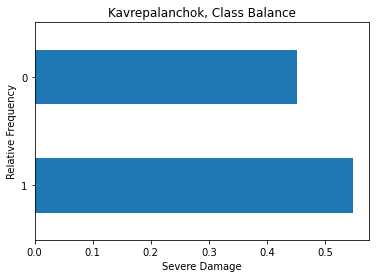

In [7]:
# Plot value counts of "severe_damage"
df["severe_damage"].value_counts(normalize = True).plot(kind = "barh")
plt.ylabel("Relative Frequency")
plt.xlabel("Severe Damage")
plt.title("Kavrepalanchok, Class Balance");

Is there a relationship between the footprint size of a building and the damage it sustained in the earthquake? 

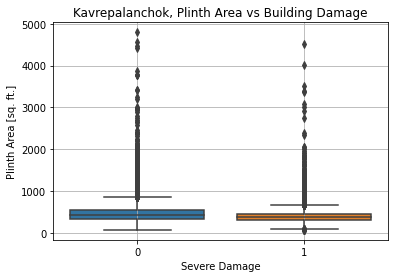

In [8]:
sns.boxplot(data =df, x = "severe_damage", y = "plinth_area_sq_ft" )
plt.grid()
plt.xlabel("Severe Damage")
plt.ylabel("Plinth Area [sq. ft.]")
plt.title("Kavrepalanchok, Plinth Area vs Building Damage");

Are buildings with certain roof types more likely to suffer severe damage?

In [9]:
roof_pivot = pd.pivot_table(
    data = df, index = "roof_type", values = "severe_damage", aggfunc = np.mean
).sort_values(by = "severe_damage")
roof_pivot

,severe_damage
roof_type,
RCC/RB/RBC,0.040715
Bamboo/Timber-Heavy roof,0.569477
Bamboo/Timber-Light roof,0.604842


# Split

Create feature matrix `X` and target vector `y`. target feature is `"severe_damage"`. 

In [10]:
target = "severe_damage"
X = df.drop(columns = target)
y = df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (76533, 11)
y shape: (76533,)


Divide dataset into training and validation sets using a randomized split. Validation set should be 20% of the total data.

In [11]:
X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size = 0.2, random_state = 42
)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (61226, 11)
y_train shape: (61226,)
X_val shape: (15307, 11)
y_val shape: (15307,)


# Build Model

## Baseline

Calculate the baseline accuracy score for your model.

In [12]:
acc_baseline = y_train.value_counts(normalize = True)[1]
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.55


Iterate

Create a model that uses logistic regression to predict building damage.

In [13]:
model_lr = make_pipeline(
        OneHotEncoder(use_cat_names = True),
        LogisticRegression(max_iter = 2000)
)
model_lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration',
                                     'superstructure'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=2000))])

Calculate training and validation accuracy score the model_lr.

In [14]:
lr_train_acc = accuracy_score(y_train, model_lr.predict(X_train))
lr_val_acc = model_lr.score(X_val, y_val)

print("Logistic Regression, Training Accuracy Score:", lr_train_acc)
print("Logistic Regression, Validation Accuracy Score:", lr_val_acc)

Logistic Regression, Training Accuracy Score: 0.6514879299643942
Logistic Regression, Validation Accuracy Score: 0.6519239563598354


Performance is poor. I'll be trying annother model

Perhaps a decision tree model will perform better than logistic regression, but what's the best hyperparameter value for `max_depth`? Create a `for` loop to train and evaluate the model `model_test` at all depths from 1 to 20.

In [15]:
# Create empty lists for training and validation accuracy scores
depth_hyperparams = range(1, 20)
training_acc = []
validation_acc = []
for d in depth_hyperparams:
     # Create model with `max_depth` of `d`
    model_test = make_pipeline(
        OrdinalEncoder(),
        DecisionTreeClassifier(max_depth = d, random_state = 42)
    )
    # Fit model to train
    model_test.fit(X_train, y_train)
    # Calculate training accuracy score and append to `training_acc`
    training_acc.append(model_test.score(X_train, y_train))
    # Calculate training accuracy score and append to `validation_acc`
    validation_acc.append(model_test.score(X_val, y_val))
                        
print("Training Accuracy Scores:", training_acc[:3])
print("Validation Accuracy Scores:", validation_acc[:3])

Training Accuracy Scores: [0.6303041191650606, 0.6303041191650606, 0.642292490118577]
Validation Accuracy Scores: [0.6350035931273273, 0.6350035931273273, 0.6453909975828053]


Using the values in `training_acc` and `validation_acc`;
- create a data frame to get the best depth for the model
- plot the validation curve for `model_test`.

In [16]:
df = pd.DataFrame(
    {
      "hyperparams": depth_hyperparams,
      "training_acc": training_acc,
      "validation_acc": validation_acc
    }
).set_index("hyperparams")



In [17]:
(
    df[
       (df["training_acc"] == df["training_acc"].max()) | 
       (df["validation_acc"] == df["validation_acc"].max())
      ]    
)

,training_acc,validation_acc
hyperparams,,
10,0.680512,0.665382
19,0.804299,0.633174


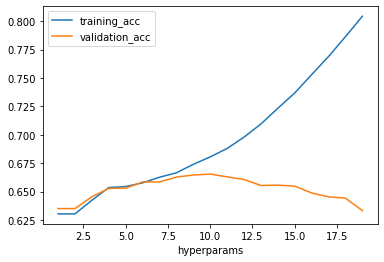

In [18]:
df.plot();

The peak of the orange line represents the best performing model. This is around `10`

Build and train a new decision tree model `final_model_dt`, using the value for `max_depth` that yielded the best validation accuracy score in your plot above. 

In [19]:
final_model =  make_pipeline(
        OrdinalEncoder(),
        DecisionTreeClassifier(max_depth = 10, random_state = 42)
)

final_model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'superstructure'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Moderate slope    2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'dat...
Building with Central Courtyard     9
H-shape                            10
NaN                                -2
dtype: int64},
                                         {'col': 'superstructure',
                   

Check for model performance on the test set?

The order of the columns in `X_test` must be the same as in the `X_train`.

In [20]:
X_test = pd.read_csv("../input/earthquake-damage/kavrepalanchok_test.csv", index_col="b_id")
assert(
    X_test.columns.all() == X_train.columns.all()
), "Make sure the order of the columns in X_test is the same as in your X_train"


In [21]:
y_test_pred = final_model.predict(X_test)
y_test_pred[:5]

array([1, 1, 1, 1, 0])

# Communicate Results

What are the most important features for `final_model`?

In [22]:
features = X_train.columns
importances = final_model.named_steps["decisiontreeclassifier"].feature_importances_
feat_imp = pd.Series(np.exp(importances), index = features).sort_values(ascending = False)
feat_imp

roof_type                 1.694519
height_ft_pre_eq          1.139658
age_building              1.119230
superstructure            1.086214
plinth_area_sq_ft         1.075868
other_floor_type          1.025659
ground_floor_type         1.013613
position                  1.011864
foundation_type           1.010017
land_surface_condition    1.008636
plan_configuration        1.004198
dtype: float64

Create a horizontal bar chart of `feat_imp`.

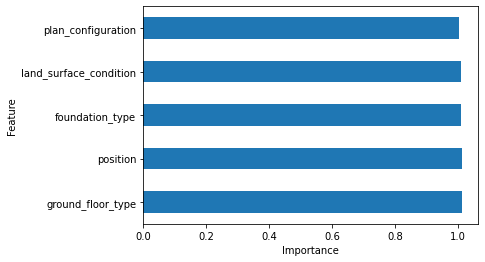

In [23]:
# Create horizontal bar chart of feature importances
feat_imp.tail(5).plot(kind = "barh")
plt.xlabel("Importance")
plt.ylabel("Feature");

# Create Interactive Dashboard

In [24]:
def predict_damage(
            age_building,
            plinth_area_sq_ft,
            height_ft_pre_eq,
            land_surface_condition,
            foundation_type,
            roof_type,
            ground_floor_type,
            other_floor_type,
            position,
            plan_configuration,
            superstructure
        ):
    data = {
                "age_building": age_building,
                "plinth_area_sq_ft": plinth_area_sq_ft,
                "height_ft_pre_eq": height_ft_pre_eq,
                "land_surface_condition": land_surface_condition,
                "foundation_type": foundation_type,
                "roof_type": roof_type,
                "ground_floor_type": ground_floor_type,
                "other_floor_type": other_floor_type,
                "position": position,
                "plan_configuration": plan_configuration,
                "superstructure": superstructure           
    }
    df = pd.DataFrame(data, index = [0])
    
    prediction = final_model.predict(df)
    if prediction == 1:
        print("Building with these properties will most likely suffer a severe damage during earthquake")
    else:
        print("The tendency that a building with these properties will suffer a severe damage during earthquake is low")
        

In [25]:
interact(
    predict_damage,
    age_building=IntSlider(
        min=X_train["age_building"].min(),
        max=X_train["age_building"].max(),
        value=X_train["age_building"].mean(),
    ),
    plinth_area_sq_ft=FloatSlider(
        min=X_train["plinth_area_sq_ft"].min(),
        max=X_train["plinth_area_sq_ft"].max(),
        step=0.01,
        value=X_train["plinth_area_sq_ft"].mean(),
    ),
    height_ft_pre_eq=FloatSlider(
        min=X_train["height_ft_pre_eq"].min(),
        max=X_train["height_ft_pre_eq"].max(),
        step=0.01,
        value=X_train["height_ft_pre_eq"].mean(),
    ),
    land_surface_condition=  Dropdown(options=sorted(X_train["land_surface_condition"].unique())),
    foundation_type=         Dropdown(options=sorted(X_train["foundation_type"].unique())),
    roof_type=               Dropdown(options=sorted(X_train["roof_type"].unique())),
    ground_floor_type=       Dropdown(options=sorted(X_train["ground_floor_type"].unique())),
    other_floor_type=        Dropdown(options=sorted(X_train["other_floor_type"].unique())),
    position=                Dropdown(options=sorted(X_train["position"].unique())),
    plan_configuration=      Dropdown(options=sorted(X_train["plan_configuration"].unique())),
    superstructure=          Dropdown(options=sorted(X_train["superstructure"].unique())),    
);

interactive(children=(IntSlider(value=34, description='age_building', max=999), FloatSlider(value=429.62875249…

## Credit
[World Quant University](https://www.wqu.edu/)